

<p align="center">
    <img src="https://github.com/GeostatsGuy/GeostatsPy/blob/master/TCG_color_logo.png?raw=true" width="220" height="240" />

</p>

## PGE 383 Graduate Student Project  

____________________



## Boston House Prices Prediction

#### Rui Zhang
#### Hildebrand Department of Petroleum & Geosystems Engineering, Cockrell School of Engineering

### Subsurface Machine Learning Course, The University of Texas at Austin
#### Hildebrand Department of Petroleum and Geosystems Engineering, Cockrell School of Engineering
#### Department of Geological Sciences, Jackson School of Geosciences






_____________________

Workflow supervision and review by:

#### Instructor: Prof. Michael Pyrcz, Ph.D., P.Eng., Associate Professor, The Univeristy of Texas at Austin
##### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

#### Course TA: Jack Xiao, Graduate Student, The University of Texas at Austin
##### [Twitter](https://twitter.com/jackxiao6) | [LinkedIn](https://www.linkedin.com/in/yuchen-jack-xiao-b1b20876/)


### Executive Summary

* We need do model rediction to investigate the pattern and relationship between the house prcies in the area of boston and the variables including tax, crime rate, weighted distances, etc.

* I first apply feature selection to reduce the dimensions from 11 to 5 predictors. After this, I perform linear regression and other regression methods to predict house prices.

* By conducting different metrics for feature selection and hyperparameter tuning for the optimal predictions. 

* This procedure may be used to predict values from other variables when they has linear relationship. 


### Import Packages

```python
import numpy as np                                        # for working with data and model arrays
```


In [1]:
import geostatspy.GSLIB as GSLIB          # GSLIB utilies, visualization and wrapper
import geostatspy.geostats as geostats    # GSLIB methods convert to Python        

In [2]:
import numpy as np                        # ndarrys for gridded data
import pandas as pd                       # DataFrames for tabular data
import os                                 # set working directory, run executables
import matplotlib.pyplot as plt           # for plotting
from scipy import stats                   # summary statistics
import math                               # trigonometry etc.
import scipy.signal as signal             # kernel for moving window calculation
import random                             # for randon numbers
import seaborn as sns                     # for matrix scatter plots
from scipy import linalg                  # for linear regression
from sklearn.feature_selection import RFE # for recursive feature selection
from sklearn.linear_model import LinearRegression # linear regression model

In [61]:
import scipy.stats as st                                    # statistical methods
from sklearn.metrics import mean_squared_error, r2_score    # specific measures to check our models
from sklearn.linear_model import Ridge                      # ridge regression implemented in scikit learn
from sklearn.linear_model import Lasso                      # the lasso implemented in scikit learn
from sklearn.model_selection import cross_val_score         # multi-processor K-fold crossvalidation
from sklearn.model_selection import train_test_split      # train and test split
from sklearn.preprocessing import StandardScaler            # standardize the features
from sklearn import metrics                                 # measures to check our models
from sklearn import tree                                  # tree program from scikit learn (package for machine learning)
from sklearn.metrics import mean_squared_error            # specific measures to check our models

### Functions

The following functions will be used in the workflow.

```python
def partial_corr(C):   #This uses the linear regression approach to compute the partial correlation
    C = np.asarray(C)
    p = C.shape[1]
    P_corr = np.zeros((p, p), dtype=np.float)
    for i in range(p):
        P_corr[i, i] = 1
        for j in range(i+1, p):
            idx = np.ones(p, dtype=np.bool)
            idx[i] = False
            idx[j] = False
            beta_i = linalg.lstsq(C[:, idx], C[:, j])[0]
            beta_j = linalg.lstsq(C[:, idx], C[:, i])[0]
            res_j = C[:, j] - C[:, idx].dot( beta_i)
            res_i = C[:, i] - C[:, idx].dot(beta_j)
            corr = stats.pearsonr(res_i, res_j)[0]
            P_corr[i, j] = corr
            P_corr[j, i] = corr
    return P_corr
```
```python
def semipartial_corr(C): # Michael Pyrcz modified the function above by Fabian Pedregosa-Izquierdo, f@bianp.net for semipartial correlation
    C = np.asarray(C)
    p = C.shape[1]
    P_corr = np.zeros((p, p), dtype=np.float)
    for i in range(p):
        P_corr[i, i] = 1
        for j in range(i+1, p):
            idx = np.ones(p, dtype=np.bool)
            idx[i] = False
            idx[j] = False
            beta_i = linalg.lstsq(C[:, idx], C[:, j])[0]
            res_j = C[:, j] - C[:, idx].dot( beta_i)
            res_i = C[:, i] # just use the value, not a residual
            corr = stats.pearsonr(res_i, res_j)[0]
            P_corr[i, j] = corr
            P_corr[j, i] = corr
    return P_corr
```

In [1]:
#Partial Correlation in Python (clone of Matlab's partialcorr)

#This uses the linear regression approach to compute the partial correlation 
#(might be slow for a huge number of variables). The algorithm is detailed here:

# http://en.wikipedia.org/wiki/Partial_correlation#Using_linear_regression

#Taking X and Y two variables of interest and Z the matrix with all the variable minus {X, Y},
#the algorithm can be summarized as
#    1) perform a normal linear least-squares regression with X as the target and Z as the predictor
#    2) calculate the residuals in Step #1
#    3) perform a normal linear least-squares regression with Y as the target and Z as the predictor
#    4) calculate the residuals in Step #3
#    5) calculate the correlation coefficient between the residuals from Steps #2 and #4; 
#    The result is the partial correlation between X and Y while controlling for the effect of Z

#Date: Nov 2014
#Author: Fabian Pedregosa-Izquierdo, f@bianp.net
#Testing: Valentina Borghesani, valentinaborghesani@gmail.com

def partial_corr(C):
#    Returns the sample linear partial correlation coefficients between pairs of variables in C, controlling 
#    for the remaining variables in C.

#    Parameters
#    C : array-like, shape (n, p)
#        Array with the different variables. Each column of C is taken as a variable
#    Returns
#    P : array-like, shape (p, p)
#        P[i, j] contains the partial correlation of C[:, i] and C[:, j] controlling
#        for the remaining variables in C.

    C = np.asarray(C)
    p = C.shape[1]
    P_corr = np.zeros((p, p), dtype=np.float)
    for i in range(p):
        P_corr[i, i] = 1
        for j in range(i+1, p):
            idx = np.ones(p, dtype=np.bool)
            idx[i] = False
            idx[j] = False
            beta_i = linalg.lstsq(C[:, idx], C[:, j])[0]
            beta_j = linalg.lstsq(C[:, idx], C[:, i])[0]
            res_j = C[:, j] - C[:, idx].dot( beta_i)
            res_i = C[:, i] - C[:, idx].dot(beta_j)
            corr = stats.pearsonr(res_i, res_j)[0]
            P_corr[i, j] = corr
            P_corr[j, i] = corr
    return P_corr

def semipartial_corr(C): # Michael Pyrcz modified the function above by Fabian Pedregosa-Izquierdo, f@bianp.net for semipartial correlation
    C = np.asarray(C)
    p = C.shape[1]
    P_corr = np.zeros((p, p), dtype=np.float)
    for i in range(p):
        P_corr[i, i] = 1
        for j in range(i+1, p):
            idx = np.ones(p, dtype=np.bool)
            idx[i] = False
            idx[j] = False
            beta_i = linalg.lstsq(C[:, idx], C[:, j])[0]
            res_j = C[:, j] - C[:, idx].dot( beta_i)
            res_i = C[:, i] # just use the value, not a residual
            corr = stats.pearsonr(res_i, res_j)[0]
            P_corr[i, j] = corr
            P_corr[j, i] = corr
    return P_corr

### Load Data

The following workflow applies the .csv file 'boston house price.csv', a dataset collected by the U.S Census Service concerning housing in the area of Boston Mass. The data was originally published by Harrison, D. and Rubinfeld, D.L. 'Hedonic prices and the demand for clean air', J. Environ. Economics & Management, vol.5, 81-102, 1978., The Edmonton Oilers Hockey Team. The dataset is publically available [here](https://www.cs.toronto.edu/~delve/data/boston/bostonDetail.html)  

We will work with the following features:

* **CRIM** - per capita crime rate by town
* **ZN** - proportion of residential land zoned for lots over 25,000 sq.ft
* **INDUS** - proportion of non-retail business acres per town.
* **CHAS** - Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
* **NOX** - nitric oxides concentration (parts per 10 million)
* **RM** - average number of rooms per dwelling
* **AGE** - proportion of owner-occupied units built prior to 1940
* **DIS** - weighted distances to five Boston employment centers
* **RAD** - index of accessibility to radial highways
* **TAX** - full-value property-tax rate per S10,000
* **LSTAT** - % lower status of the population
* **MEDV** - Median value of owner-occupied homes in $1000's

```python
os.chdir(r"C:\Users\Rui\Desktop\ML\project")   # set the working directory
df = pd.read_csv('boston house price.csv')       # load our data table
```


In [4]:
os.chdir(r"C:\Users\Rui\Desktop\ML\project")                     # set the working directory

In [5]:
df = pd.read_csv('boston house price.csv')  # load our data table 

### Basic Data Checking and Visualization

Firstly we can preview the DataFrame by using the 'head' DataFrame member function 


In [6]:
df.head(n=6)                             # we could also use this command for a table preview

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1,296.0,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2,242.0,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2,242.0,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3,222.0,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3,222.0,5.33,36.2
5,0.02985,0.0,2.18,0.0,0.458,6.430,58.7,6.0622,3,222.0,5.21,28.7


Below shows the calculated summary statistics.

In [7]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
CRIM,506.0,1.269195,2.399207,0.0000,0.049442,0.144655,0.819622,9.96654
ZN,506.0,13.295257,23.048697,0.0000,0.000000,0.000000,18.100000,100.00000
INDUS,506.0,9.205158,7.169630,0.0000,3.440000,6.960000,18.100000,27.74000
CHAS,506.0,0.140765,0.312765,0.0000,0.000000,0.000000,0.000000,1.00000
NOX,506.0,1.101175,1.646991,0.3850,0.449000,0.538000,0.647000,7.31300
RM,506.0,15.679800,27.220206,3.5610,5.961500,6.322500,6.949000,100.00000
AGE,506.0,58.744660,33.104049,1.1370,32.000000,65.250000,89.975000,100.00000
DIS,506.0,6.173308,6.476435,1.1296,2.430575,3.925850,6.332075,24.00000
RAD,506.0,78.063241,203.542157,1.0000,4.000000,5.000000,24.000000,666.00000
TAX,506.0,339.317787,180.670077,20.2000,254.000000,307.000000,403.000000,711.00000



* Then we calculate the feature ranges of the data like this:

In [12]:
crimmin = 0; crimmax = 10; crimname = 'CRIME'; crimtitle = 'CRIME' # user specified min and max values, and labels for plotting
znmin = 0.0; znmax = 100; znname = 'ZN'; zntitle = 'ZN'                
indusmin = 0; indusmax = 28.0; indusname = 'INDUS'; industitle = 'INDUS'
chasmin = 0.0; chasmax = 1; chasname = 'CHAS'; chastitle = 'CHAS'
noxmin = 0.0; noxmax = 7.5; noxname = 'NOX'; noxtitle = 'NOX' 
rmmin = 3.5; rmmax = 100; rmname = 'RM'; rmtitle = 'RM'
agemin = 1; agemax = 100; agename = 'AGE'; agetitle = 'AGE'
dismin = 1; dismax = 24; disname = 'DIS'; distitle = 'DIS'
radmin = 1; radmax = 666; radname = 'RAD'; radtitle = 'RAD'
taxmin = 20; taxmax = 711; taxname = 'TAX'; taxtitle = 'TAX'
lstatmin = 1; lstatmax = 38; lstatname = 'LSTAT'; lstattitle = 'LSTAT'
medvmin = 5; medvmax = 50; medvname = 'MEDV'; medvtitle = 'MEDV'

### Univariate Distributions

As with summary statistics, this method can check the data and assess the confidence with each feature. 

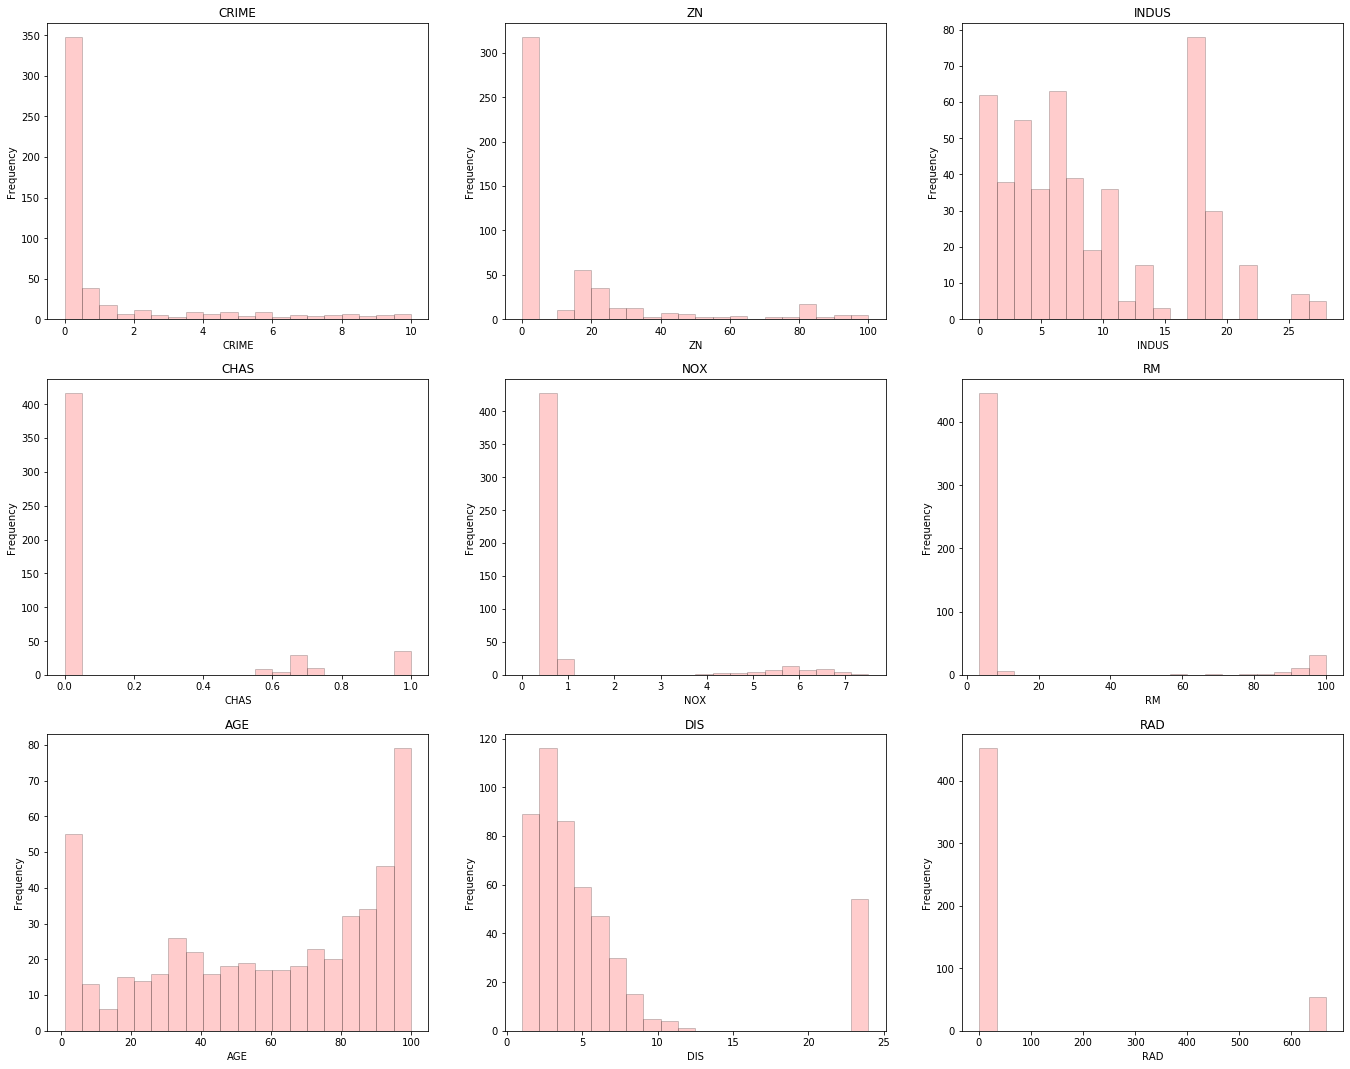

In [10]:
plt.subplot(331)
GSLIB.hist_st(df['CRIM'].values,crimmin,crimmax,log=False,cumul = False,bins=20,weights = None,xlabel=crimname,title=crimtitle)

plt.subplot(332)
GSLIB.hist_st(df['ZN'].values,znmin,znmax,log=False,cumul = False,bins=20,weights = None,xlabel=znname,title=zntitle)

plt.subplot(333)
GSLIB.hist_st(df['INDUS'].values,indusmin,indusmax,log=False,cumul = False,bins=20,weights = None,xlabel=indusname,title=industitle)

plt.subplot(334)
GSLIB.hist_st(df['CHAS'].values,chasmin,chasmax,log=False,cumul = False,bins=20,weights = None,xlabel=chasname,title=chastitle)

plt.subplot(335)
GSLIB.hist_st(df['NOX'].values,noxmin,noxmax,log=False,cumul = False,bins=20,weights = None,xlabel=noxname,title=noxtitle)

plt.subplot(336)
GSLIB.hist_st(df['RM'].values,rmmin,rmmax,log=False,cumul = False,bins=20,weights = None,xlabel=rmname,title=rmtitle)

plt.subplot(337)
GSLIB.hist_st(df['AGE'].values,agemin,agemax,log=False,cumul = False,bins=20,weights = None,xlabel=agename,title=agetitle)

plt.subplot(338)
GSLIB.hist_st(df['DIS'].values,dismin,dismax,log=False,cumul = False,bins=20,weights = None,xlabel=disname,title=distitle)

plt.subplot(339)
GSLIB.hist_st(df['RAD'].values,radmin,radmax,log=False,cumul = False,bins=20,weights = None,xlabel=radname,title=radtitle)

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=3.5, wspace=0.2, hspace=0.2)
plt.savefig('hist_Porosity_Multiple_bins1.tif',dpi=600,bbox_inches="tight")
plt.show()

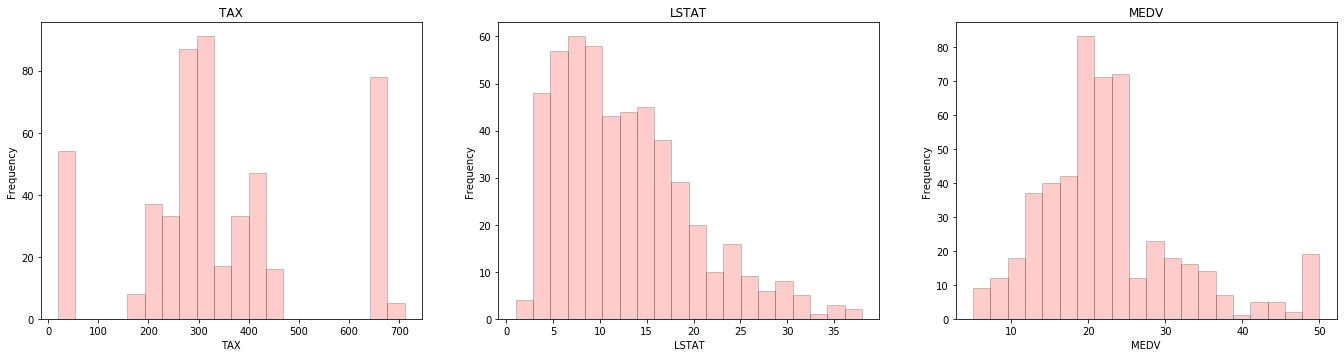

In [14]:
plt.subplot(331)
GSLIB.hist_st(df['TAX'].values,taxmin,taxmax,log=False,cumul = False,bins=20,weights = None,xlabel=taxname,title=taxtitle)


plt.subplot(332)
GSLIB.hist_st(df['LSTAT'].values,lstatmin,lstatmax,log=False,cumul = False,bins=20,weights = None,xlabel=lstatname,title=lstattitle)

plt.subplot(333)
GSLIB.hist_st(df['MEDV'].values,medvmin,medvmax,log=False,cumul = False,bins=20,weights = None,xlabel=medvname,title=medvtitle)

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=3.5, wspace=0.2, hspace=0.2)
plt.savefig('hist_Porosity_Multiple_bins2.tif',dpi=600,bbox_inches="tight")
plt.show()

The univariate distributions look good:

* there are no obvious outliers

### Bivariate Distributions

Matrix scatter plots can help us observe the bivarate relationships between the variables.  

* this is another opportunity through data visualization to identify data issues
* we can assess if we have collinearity, specifically simpler form between two features at a time. 


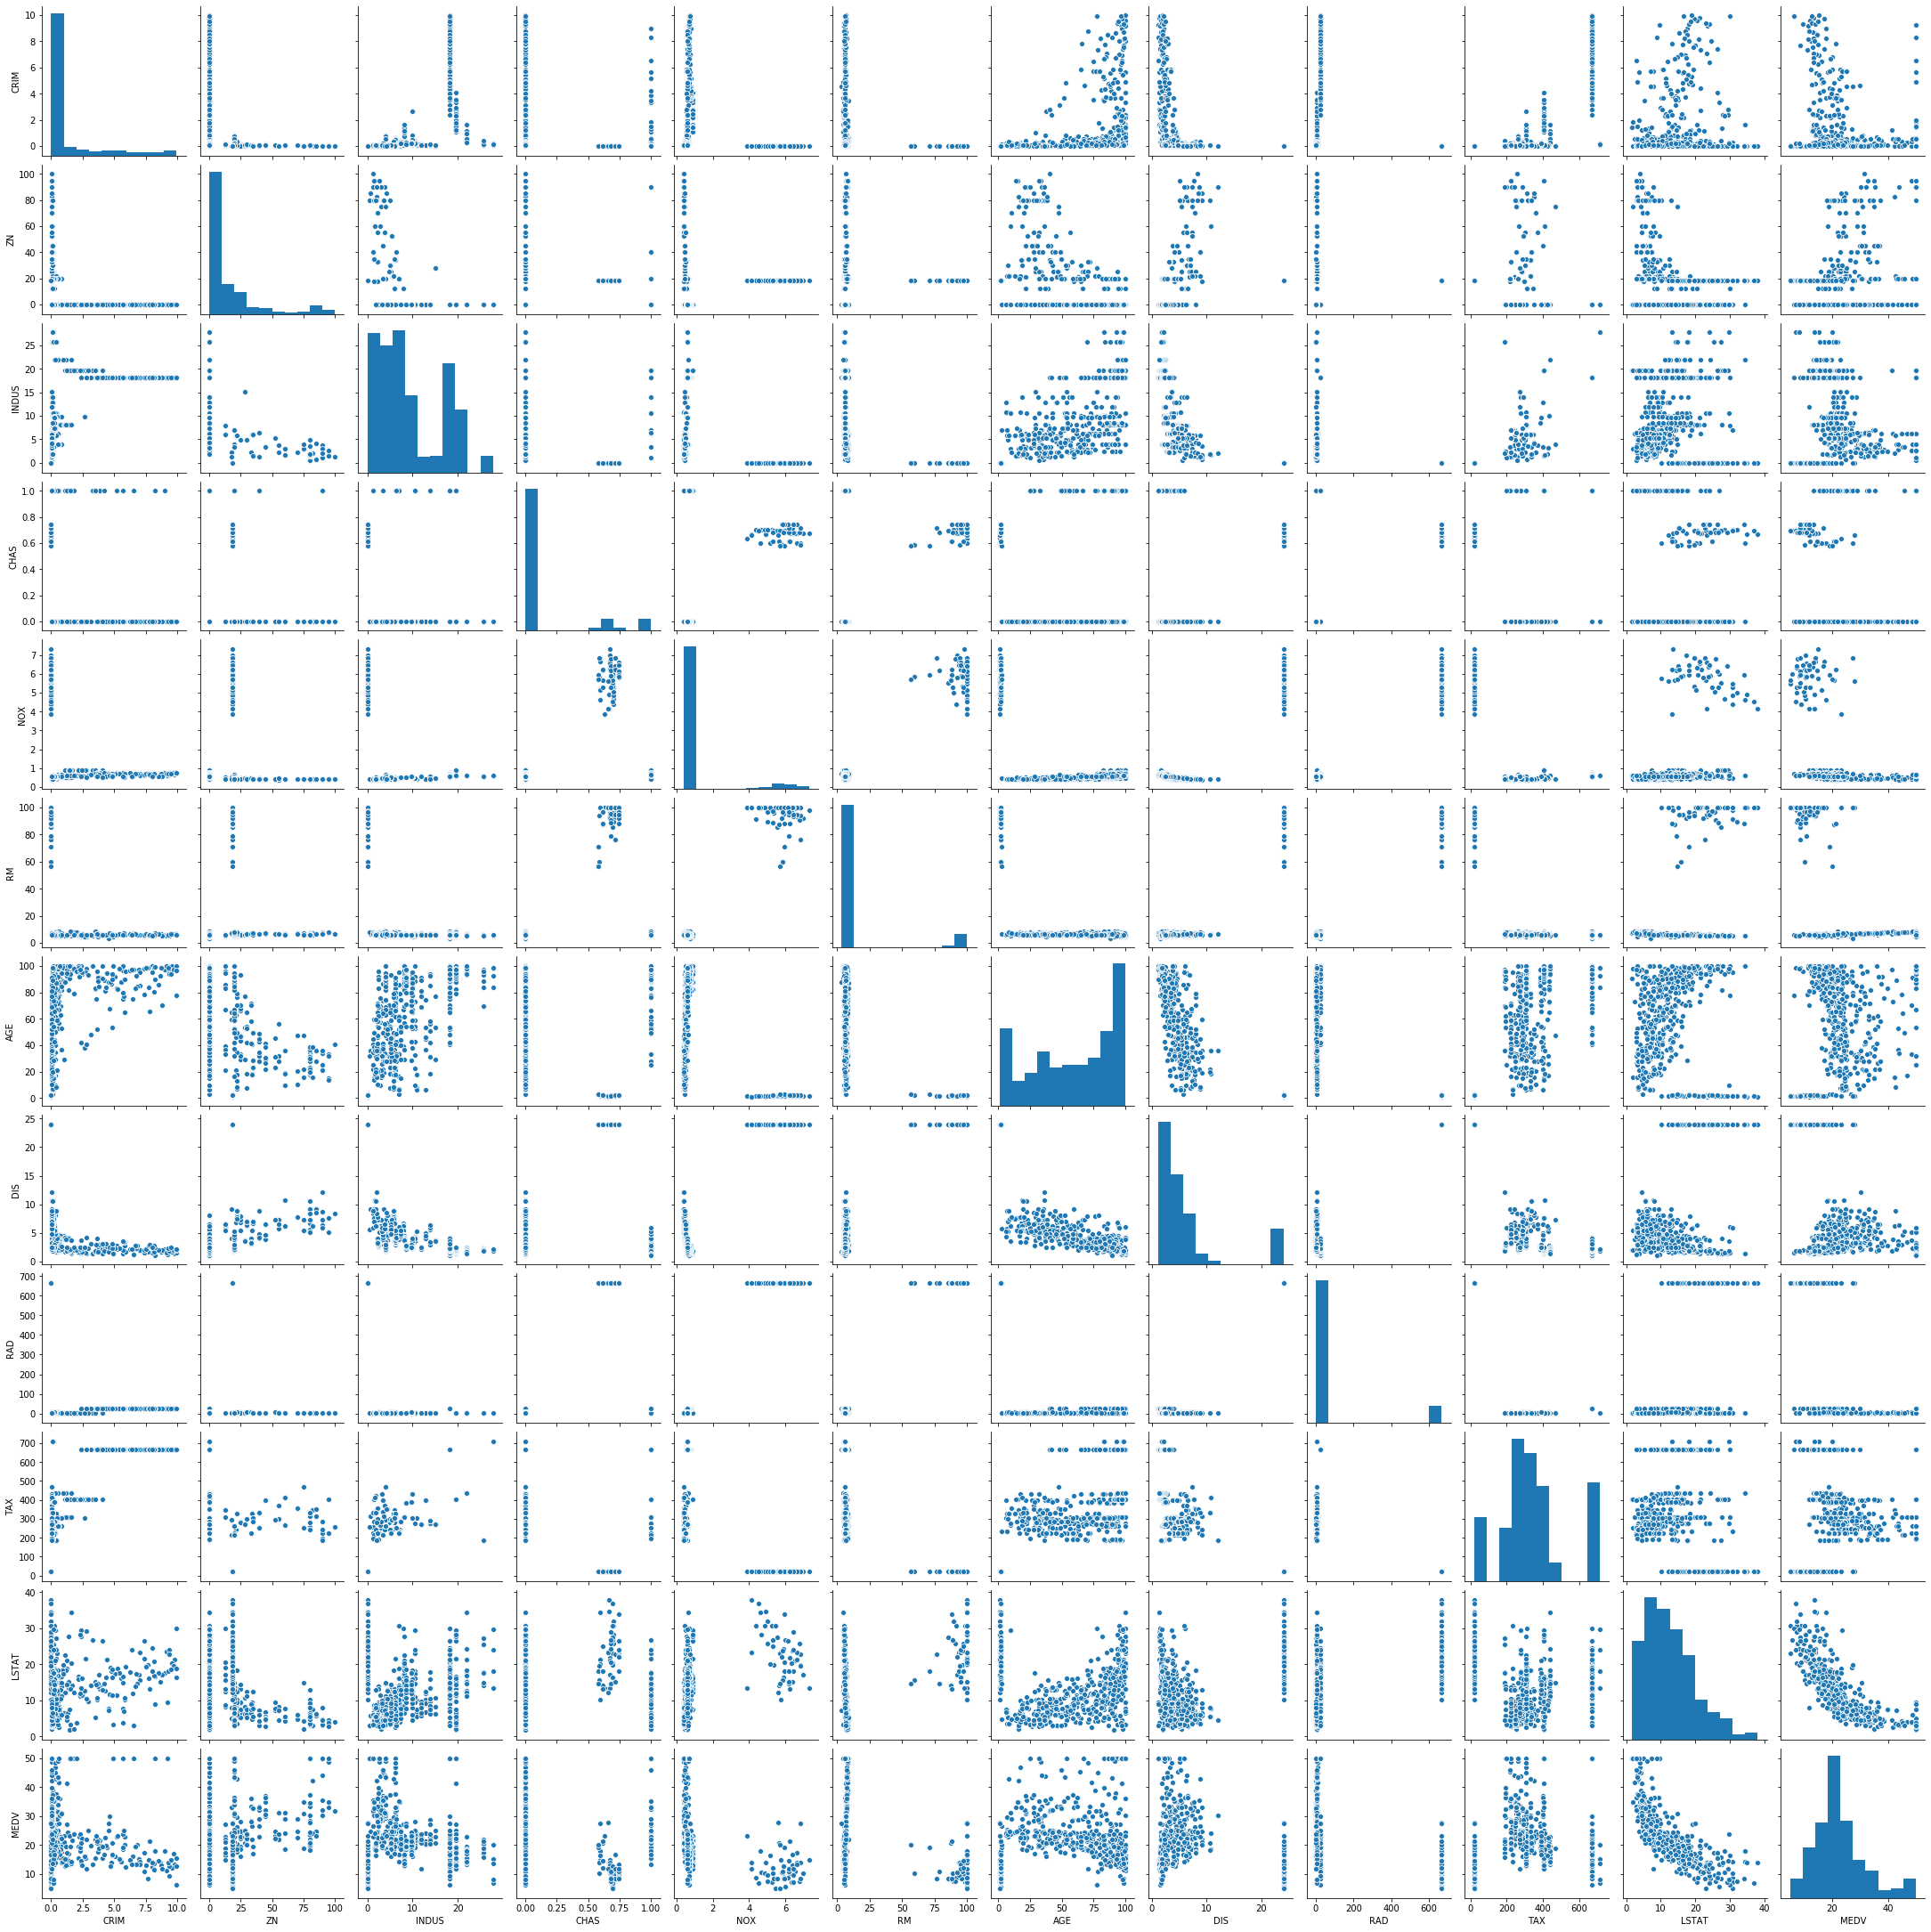

In [15]:
sns.pairplot(df,vars=['CRIM','ZN','INDUS','CHAS','NOX','RM','AGE','DIS','RAD','TAX','LSTAT','MEDV'],markers='o')

* We can also observe the full correlation matrix to evaluate the potential for redudancy between predictor features.

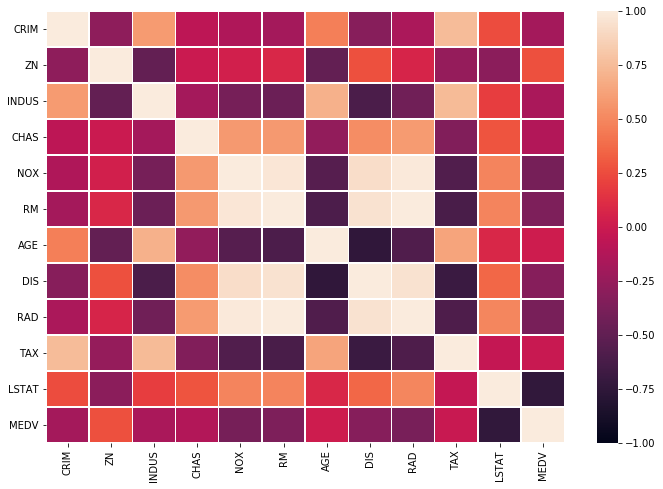

In [16]:
plt.subplot(111)                          # plot a color coded correlation matrix
sns.heatmap(df.iloc[:,0:12].corr(),vmin = -1.0, vmax = 1.0,linewidths=.5, fmt= '.1f')
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.5, top=1.5, wspace=0.2, hspace=0.2)
plt.show()

### Boston House Prices Prediction


1. Datasets preparation

2. Datasets checking and visulizations

3. Apply various methods for fearture selection

4. Perform linear regression, ridge regression, and lasso regression for prediction models

5. Obtain final results and summary

### 1. First Workflow Step-Feature Selection

This data set contains 11 predictors and one response feature, I need to do feature selection to reduce the dimensions.


Covariance:
* measures the linear relationship between features
* sensitive to the variance of both the predictor and response features

In [17]:
covariance = df.iloc[:,0:12].cov().iloc[11,:11]
print(covariance)

CRIM      -4.071779
ZN        57.588988
INDUS    -10.794635
CHAS      -0.337454
NOX       -6.011243
RM       -91.884513
AGE        3.242426
DIS      -19.466832
RAD     -730.241485
TAX      -22.434050
LSTAT    -48.447538
Name: MEDV, dtype: float64


correlation coefficient:

* measures the linear relationship betwwen features
* not sensitive to the variance of both the predictor and response features


In [19]:
correlation = df.iloc[:,0:12].corr().iloc[11,:11]
print(correlation)

CRIM    -0.184529
ZN       0.271670
INDUS   -0.163704
CHAS    -0.117313
NOX     -0.396846
RM      -0.367029
AGE      0.010650
DIS     -0.326820
RAD     -0.390087
TAX     -0.013501
LSTAT   -0.737663
Name: MEDV, dtype: float64


From above:

* We see that LSTAT has the strongest linear negative relationships with MEDV. 


rank correlation:

* measures the monotonic relationship between features, relaxes the linear assumption
* not so sensitive to the dispersion or variance of both the predictor and response

In [20]:
rank_correlation, rank_correlation_pval = stats.spearmanr(df.iloc[:,0:12]) # calculate the range correlation coefficient
rank_correlation = rank_correlation[:,11][:11]
rank_correlation_pval = rank_correlation_pval[:,11][:11]
print(rank_correlation)
print(rank_correlation_pval)

[-0.10201709  0.22812539 -0.17361268 -0.22202442 -0.58268627  0.27921001
 -0.13631386  0.0128463  -0.36476465 -0.12292661 -0.85291414]
[2.17255007e-002 2.13230049e-007 8.65456043e-005 4.53362923e-007
 2.44068630e-047 1.62970589e-010 2.11863838e-003 7.73141894e-001
 2.27595433e-017 5.62571071e-003 2.22172752e-144]


partial correlation: 

* provides a measure of the linear relationship between $X$ and $Y$ while controlling for the effect of $Z$ other features on both, $X$ and $Y$. 


In [23]:
partial_correlation = partial_corr(df.iloc[:,0:12]) # calculate the partial correlation coefficients
partial_correlation = partial_correlation[:,11][:11] # extract a single row and remove production with itself
print(partial_correlation)

[-0.13968413  0.16786105 -0.01956387  0.17057696  0.07456388  0.30467334
  0.4358801   0.29714997 -0.33270052  0.23336858 -0.47494767]


semipartial correlation coefficient:

* provides a measure of the linear relationship between $X$ and $Y$ while controlling for the effect of $Z$ other predictor features on the predictor feature, $X$, to get the unique contribution of $X$ with respect to $Y$. 


In [24]:
semipartial_correlation = semipartial_corr(df.iloc[:,0:12]) # calculate the semi-partial correlation coefficients
semipartial_correlation = semipartial_correlation[:,11][:11] # extract a single row and remove production with itself
print(semipartial_correlation)

[-0.12617863  0.07101702 -0.12301248  0.09635671 -0.04807544 -0.01887582
  0.06022465 -0.04157448 -0.07454207 -0.08384538 -0.45476599]


We then plot all the results from the above quantitative methods.


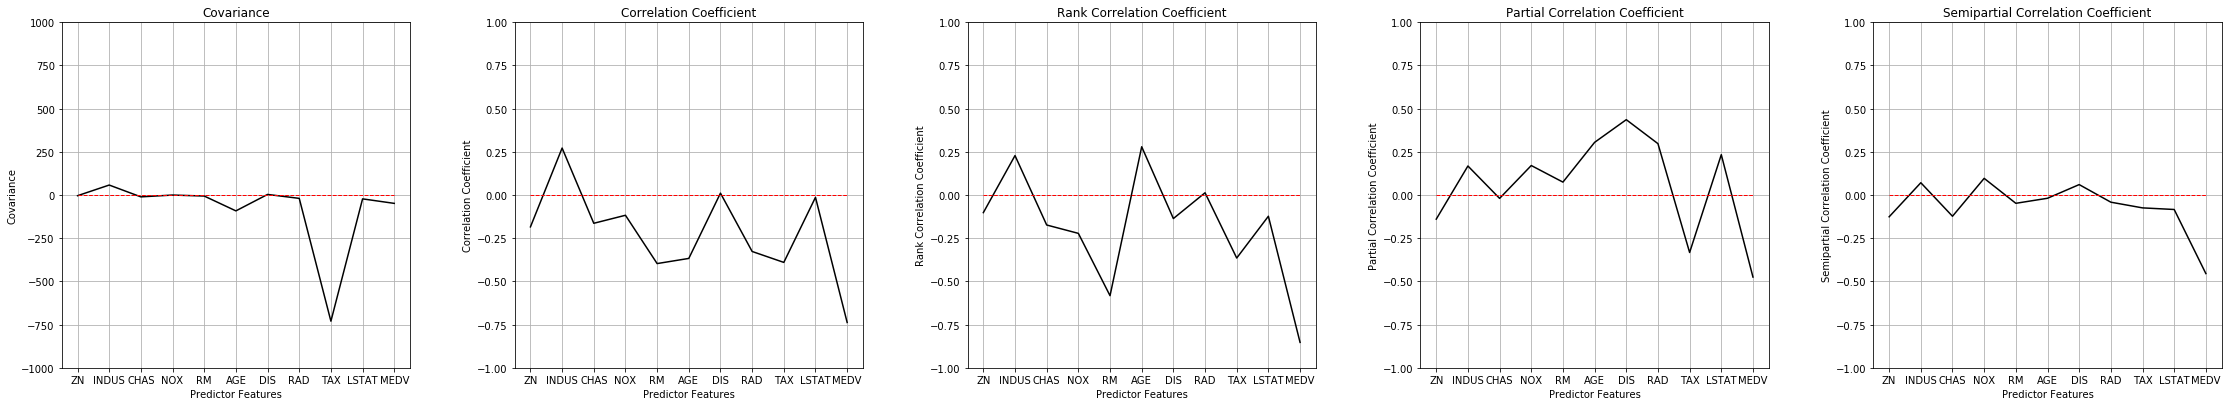

In [25]:
features = df.columns.values[1:][:11]
plt.subplot(151)
plt.plot(features,covariance,color='black')
plt.plot([0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],'r--',color='red',linewidth = 1.0)
plt.xlabel('Predictor Features')
plt.ylabel('Covariance')
t = plt.title('Covariance')
plt.ylim(-1000,1000)
plt.grid(True)

plt.subplot(152)
plt.plot(features,correlation,color='black')
plt.plot([0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],'r--',color='red',linewidth = 1.0)
plt.xlabel('Predictor Features')
plt.ylabel('Correlation Coefficient')
t = plt.title('Correlation Coefficient')
plt.ylim(-1,1)
plt.grid(True)

plt.subplot(153)
plt.plot(features,rank_correlation,color='black')
plt.plot([0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],'r--',color='red',linewidth = 1.0)
plt.xlabel('Predictor Features')
plt.ylabel('Rank Correlation Coefficient')
t = plt.title('Rank Correlation Coefficient')
plt.ylim(-1,1)
plt.grid(True)

plt.subplot(154)
plt.plot(features,partial_correlation,color='black')
plt.plot([0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],'r--',color='red',linewidth = 1.0)
plt.xlabel('Predictor Features')
plt.ylabel('Partial Correlation Coefficient')
t = plt.title('Partial Correlation Coefficient')
plt.ylim(-1,1)
plt.grid(True)

plt.subplot(155)
plt.plot(features,semipartial_correlation,color='black')
plt.plot([0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],'r--',color='red',linewidth = 1.0)
plt.xlabel('Predictor Features')
plt.ylabel('Semipartial Correlation Coefficient')
t = plt.title('Semipartial Correlation Coefficient')
plt.ylim(-1,1)
plt.grid(True)

plt.subplots_adjust(left=0.0, bottom=0.0, right=5, top=1.2, wspace=0.3, hspace=0.2)
plt.show()

We are converging on INDUS, TAX, RM as the most important variables with respect to linear relationships with the MEDV.  


### Repeat with Standardization or Normal Score Transform of All Features

Now we standardize all the features and repeat the previously methods. 

We perform affine correction of the features, it can scale the distributions to have $\overline{x} = 0$ and $\sigma_x = 1.0$.


In [27]:
dfS = pd.DataFrame()                      # affine correction of each feature, standardization to a mean of 0 and variance of 1 
dfS['CRIM'] = df['CRIM'].values
dfS['ZN'] = GSLIB.affine(df['ZN'].values,0.0,1.0)
dfS['INDUS'] = GSLIB.affine(df['INDUS'].values,0.0,1.0)
dfS['CHAS'] = GSLIB.affine(df['CHAS'].values,0.0,1.0)
dfS['NOX'] = GSLIB.affine(df['NOX'].values,0.0,1.0)
dfS['RM'] = GSLIB.affine(df['RM'].values,0.0,1.0)
dfS['AGE'] = GSLIB.affine(df['AGE'].values,0.0,1.0)
dfS['DIS'] = GSLIB.affine(df['DIS'].values,0.0,1.0)
dfS['RAD'] = GSLIB.affine(df['RAD'].values,0.0,1.0)
dfS['TAX'] = GSLIB.affine(df['TAX'].values,0.0,1.0)
dfS['LSTAT'] = GSLIB.affine(df['LSTAT'].values,0.0,1.0)
dfS['MEDV'] = GSLIB.affine(df['MEDV'].values,0.0,1.0)
dfS.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,LSTAT,MEDV
0,0.00632,0.204324,-0.962669,-0.450511,-0.342280,-0.334818,0.195195,-0.321993,-0.378985,-0.239999,-1.075562,0.159686
1,0.02731,-0.577404,-0.298101,-0.450511,-0.384216,-0.340481,0.609451,-0.186430,-0.374068,-0.539182,-0.492439,-0.101524
2,0.02729,-0.577404,-0.298101,-0.450511,-0.384216,-0.312386,0.071220,-0.186430,-0.374068,-0.539182,-1.208727,1.324247
3,0.03237,-0.577404,-0.980819,-0.450511,-0.390902,-0.319263,-0.391416,-0.017173,-0.369150,-0.649991,-1.361517,1.182758
4,0.06905,-0.577404,-0.980819,-0.450511,-0.390902,-0.313783,-0.137420,-0.017173,-0.369150,-0.649991,-1.026501,1.487503


We perform normal score transform of the features:


In [28]:
dfS = pd.DataFrame()                      # Gaussian transform of each feature, standardization to a mean of 0 and variance of 1 
dfS['CRIM'] = df['CRIM'].values
dfS['ZN'],d1,d2 = geostats.nscore(df,'ZN')
dfS['INDUS'],d1,d2 = geostats.nscore(df,'INDUS')
dfS['CHAS'],d1,d2 = geostats.nscore(df,'CHAS')
dfS['NOX'],d1,d2 = geostats.nscore(df,'NOX')
dfS['RM'],d1,d2 = geostats.nscore(df,'RM')
dfS['AGE'],d1,d2 = geostats.nscore(df,'AGE')
dfS['DIS'],d1,d2 = geostats.nscore(df,'DIS')
dfS['RAD'],d1,d2 = geostats.nscore(df,'RAD')
dfS['TAX'],d1,d2 = geostats.nscore(df,'TAX')
#dfS['PTRATIO'],d1,d2 = geostats.nscore(df,'PTRATIO')
dfS['LSTAT'],d1,d2 = geostats.nscore(df,'LSTAT')
dfS['MEDV'],d1,d2 = geostats.nscore(df,'MEDV')

dfS.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,LSTAT,MEDV
0,0.00632,0.388524,-0.927331,0.927331,0.091774,0.361947,-0.002477,0.076860,-1.767915,-0.171747,-1.167315,0.503483
1,0.02731,0.325161,0.012385,0.927331,-0.531804,0.161701,0.278495,0.319943,-1.366007,-0.777678,-0.330388,0.057000
2,0.02729,0.325161,0.012385,0.927331,-0.531804,0.853683,-0.076860,0.319943,-1.366007,-0.777678,-1.504662,1.271482
3,0.03237,0.325161,-0.966104,0.927331,-0.607562,0.731577,-0.335624,0.601614,-0.990081,-0.982026,-2.230840,1.238812
4,0.06905,0.325161,-0.966104,0.927331,-0.607562,0.811644,-0.181811,0.601614,-0.990081,-0.982026,-1.048374,1.404806


We also check the matrix scatter plot again.


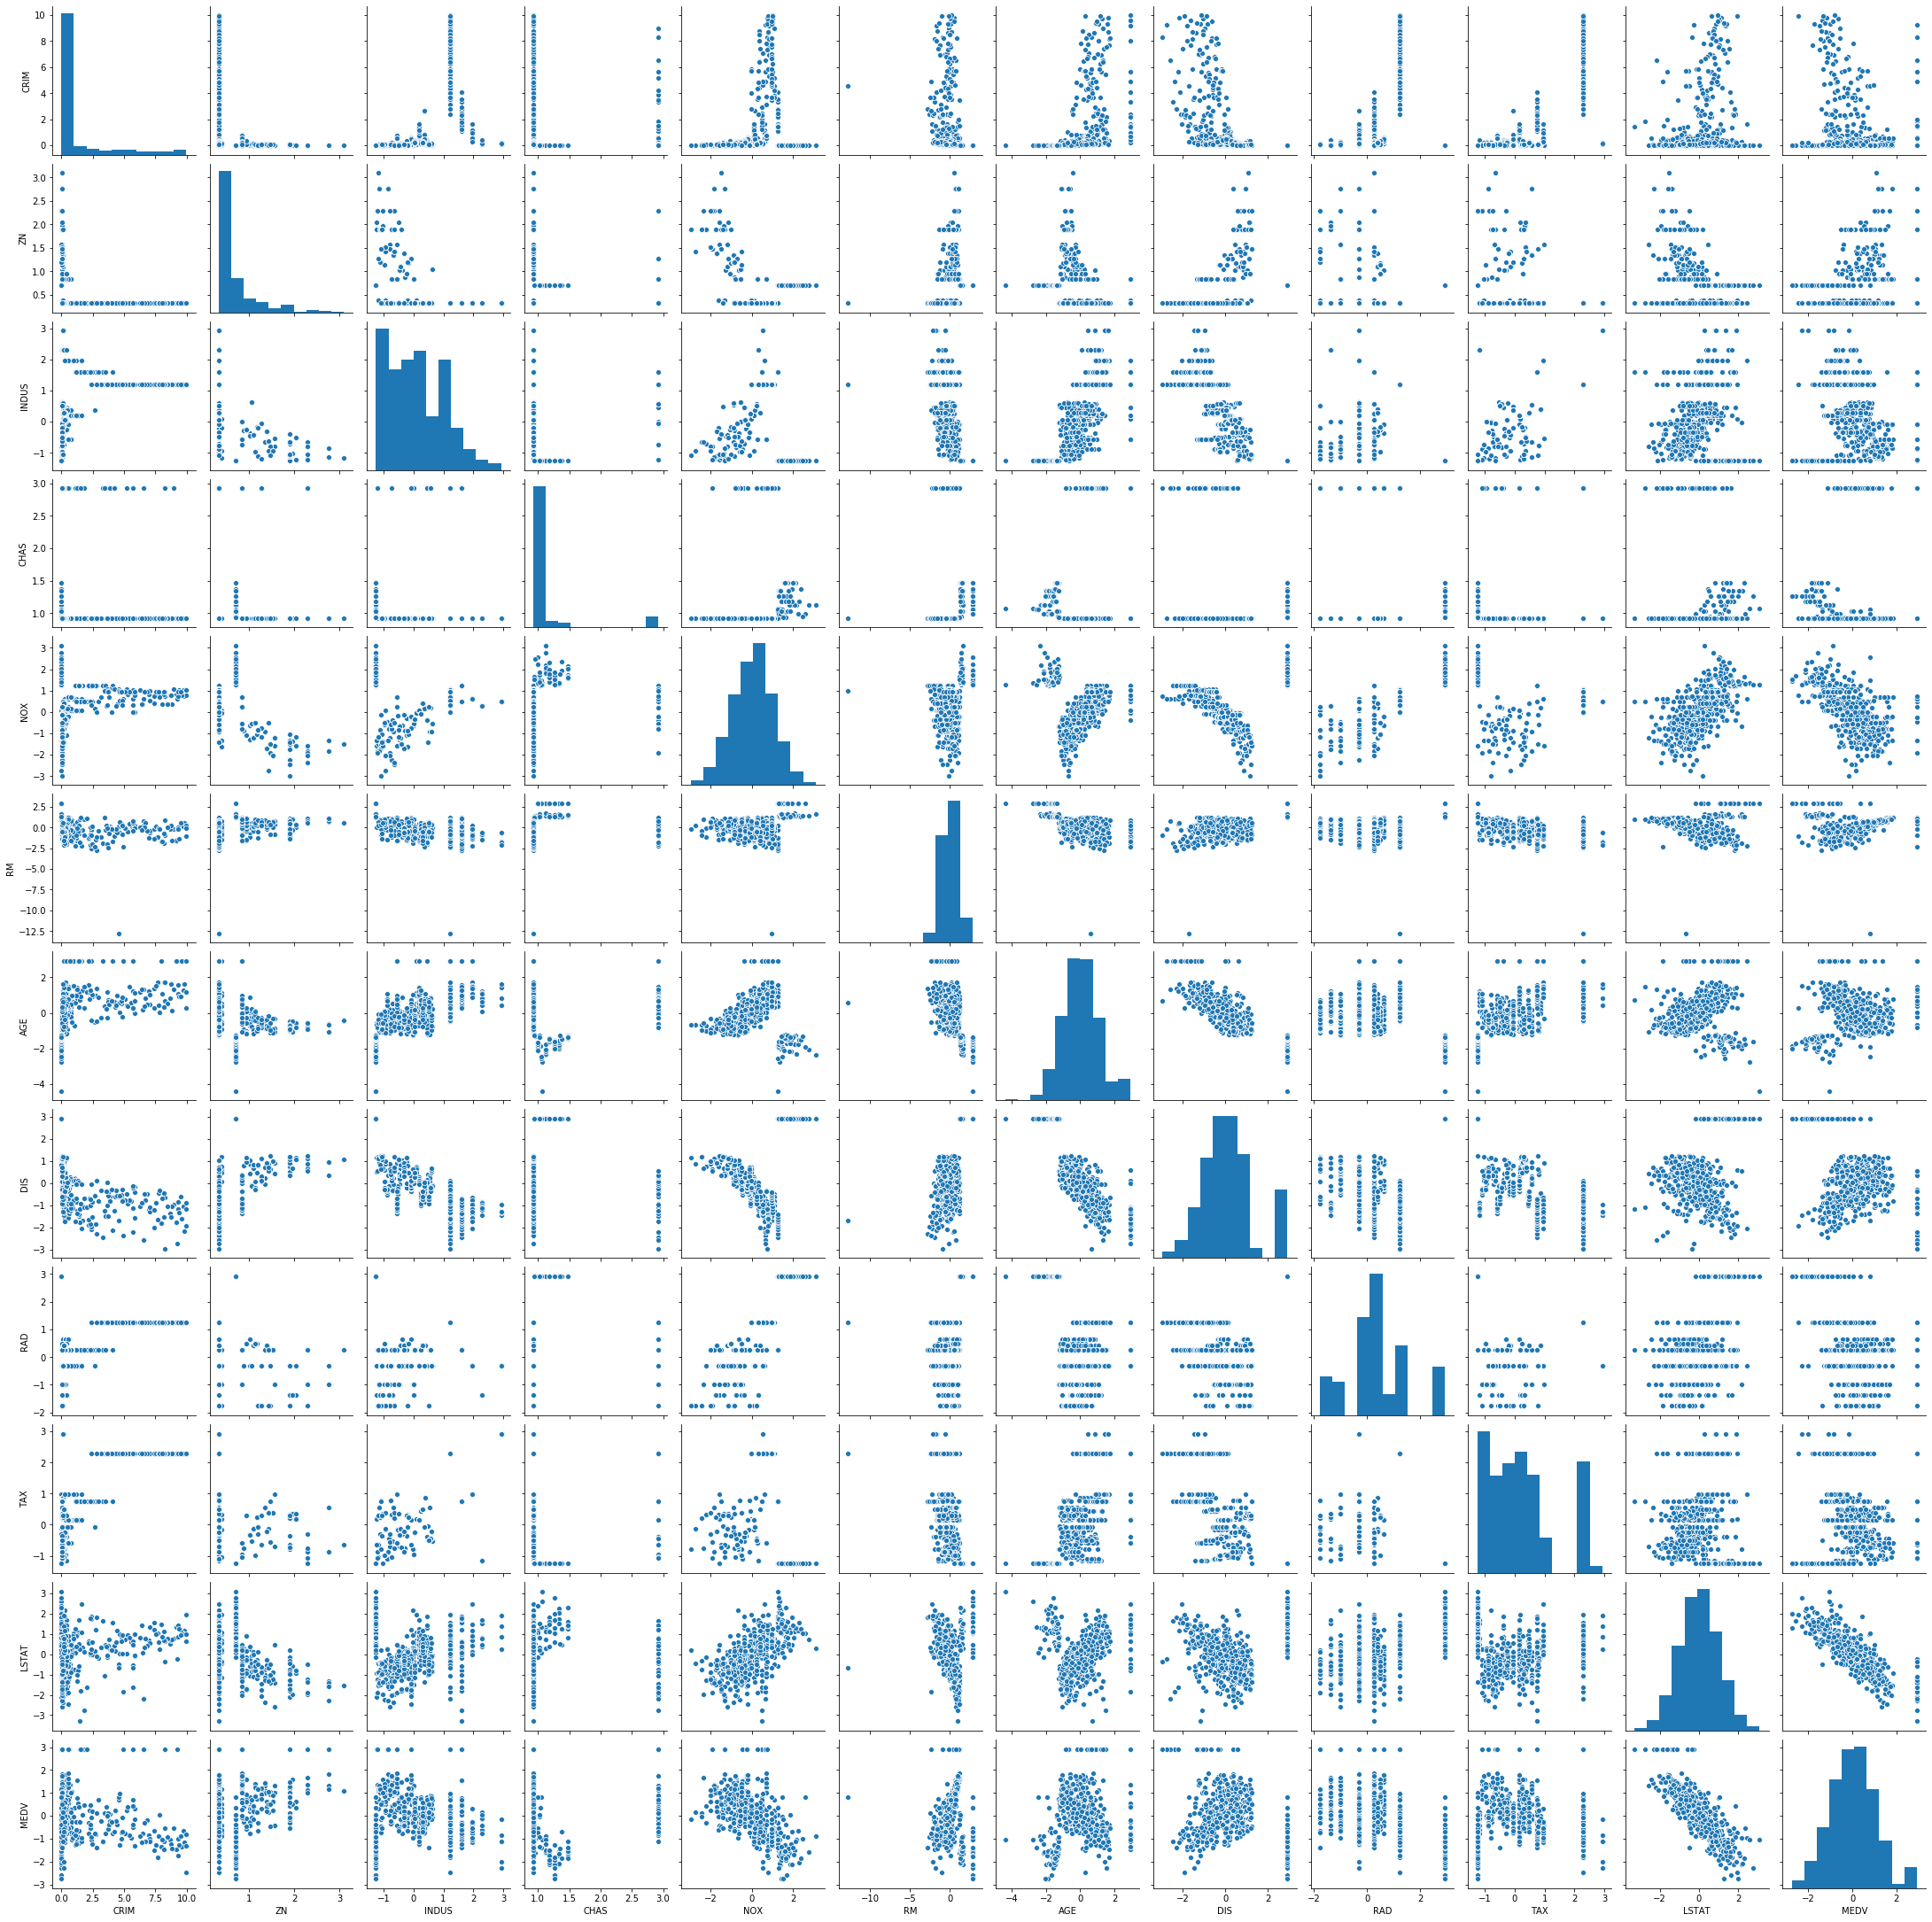

In [29]:
sns.pairplot(dfS,vars=['CRIM','ZN','INDUS','CHAS','NOX','RM','AGE','DIS','RAD','TAX','LSTAT','MEDV'],markers='o')


Below is the new DataFrame with standardized variables. We will repeat the previous calculations.

In [30]:
stand_covariance = dfS.iloc[:,0:12].cov().iloc[11,:11]
stand_correlation = dfS.iloc[:,0:12].corr().iloc[11,:11]
stand_rank_correlation, stand_rank_correlation_pval = stats.spearmanr(dfS.iloc[:,0:12])
stand_rank_correlation = stand_rank_correlation[:,11][:11]
stand_rank_correlation_pval = stand_rank_correlation_pval[:,11][:11]
stand_partial_correlation = partial_corr(dfS.iloc[:,0:12])
stand_partial_correlation = stand_partial_correlation[:,11][:11]
stand_semipartial_correlation = semipartial_corr(dfS.iloc[:,0:12])
stand_semipartial_correlation = stand_semipartial_correlation[:,11][:11]

We plot all the results from methods again:

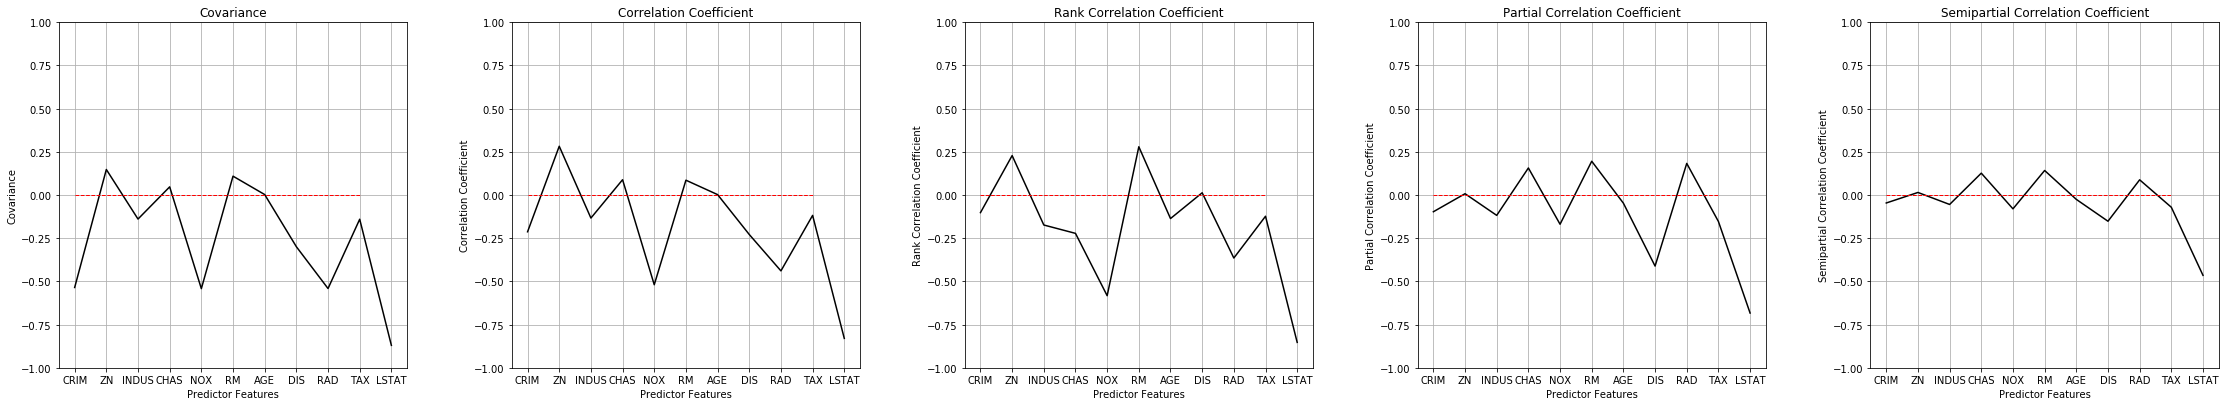

In [31]:
features = df.columns.values[0:][:11]
plt.subplot(151)
plt.plot(features,stand_covariance,color='black')
plt.plot([0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],'r--',color='red',linewidth = 1.0)
plt.xlabel('Predictor Features')
plt.ylabel('Covariance')
t = plt.title('Covariance')
plt.ylim(-1,1)
plt.grid(True)

plt.subplot(152)
plt.plot(features,stand_correlation,color='black')
plt.plot([0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],'r--',color='red',linewidth = 1.0)
plt.xlabel('Predictor Features')
plt.ylabel('Correlation Coefficient')
t = plt.title('Correlation Coefficient')
plt.ylim(-1,1)
plt.grid(True)

plt.subplot(153)
plt.plot(features,stand_rank_correlation,color='black')
plt.plot([0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],'r--',color='red',linewidth = 1.0)
plt.xlabel('Predictor Features')
plt.ylabel('Rank Correlation Coefficient')
t = plt.title('Rank Correlation Coefficient')
plt.ylim(-1,1)
plt.grid(True)

plt.subplot(154)
plt.plot(features,stand_partial_correlation,color='black')
plt.plot([0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],'r--',color='red',linewidth = 1.0)
plt.xlabel('Predictor Features')
plt.ylabel('Partial Correlation Coefficient')
t = plt.title('Partial Correlation Coefficient')
plt.ylim(-1,1)
plt.grid(True)

plt.subplot(155)
plt.plot(features,stand_semipartial_correlation,color='black')
plt.plot([0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],'r--',color='red',linewidth = 1.0)
plt.xlabel('Predictor Features')
plt.ylabel('Semipartial Correlation Coefficient')
t = plt.title('Semipartial Correlation Coefficient')
plt.ylim(-1,1)
plt.grid(True)

plt.subplots_adjust(left=0.0, bottom=0.0, right=5, top=1.2, wspace=0.3, hspace=0.2)
plt.show()

We can observe that:

* now covariance is equal to correlation coefficient; the semipartial correlations are sensitive to the feature standardization.

* According to the plots, I think the DIS, RAD, RM are the most important features.

### Mutual Information

Mutual information can quantify the mutual dependence between two features.  

* no assumption about the relationship 

* compares the joint probabilities to the product of the marginal probabilities


Feature ranking:
1. feature LSTAT = 1.000000
2. feature RM = 0.735385
3. feature INDUS = 0.715473
4. feature AGE = 0.623653
5. feature TAX = 0.539103
6. feature NOX = 0.477689
7. feature DIS = 0.467653
8. feature CRIM = 0.407786
9. feature ZN = 0.366600
10. feature RAD = 0.317181
11. feature CHAS = 0.263511


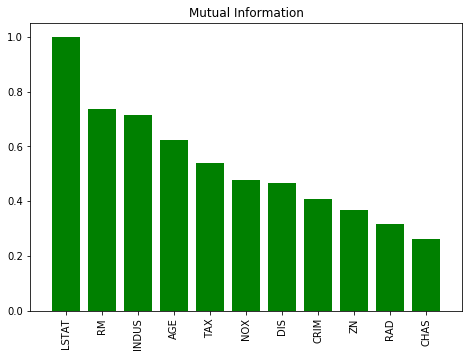

In [32]:
from sklearn.feature_selection import mutual_info_regression

x = df.iloc[:,[0,1,2,3,4,5,6,7,8,9,10]]              # separate DataFrames for predictor and response features
y = df.iloc[:,[11]]

mi = mutual_info_regression(x,np.ravel(y)) # calculate mutual information
mi /= np.max(mi)                          # calculate relative mutual information

indices = np.argsort(mi)[::-1]            # find indicies for descending order

print("Feature ranking:")                 # write out the feature importances
for f in range(x.shape[1]):
    print("%d. feature %s = %f" % (f + 1, x.columns[indices][f], mi[indices[f]]))

plt.subplot(111)                          # plot the relative mutual information 
plt.title("Mutual Information")
plt.bar(range(x.shape[1]), mi[indices],
       color="g", align="center")
plt.xticks(range(x.shape[1]), x.columns[indices],rotation=90)
plt.xlim([-1, x.shape[1]])
plt.subplots_adjust(left=0.0, bottom=0.0, right=1., top=1., wspace=0.2, hspace=0.2)
plt.show()



From mutual information, we observe that LSTAT, RM then INDUS and AGE have the greatest departure from general independence.  

### $B$ Coefficients / Beta Weights 

We could also consider $B$ coefficients.

In [33]:
linear_reg = LinearRegression().fit(df.iloc[:,[0,1,2,3,4,5,6,7,8,9,10]].values,df.iloc[:,[11]].values)
print('Features: ' + str(df.columns[0:11].values))
b = np.round(linear_reg.coef_,2)[0]
print('B coefficients:' + str(b))

Features: ['CRIM' 'ZN' 'INDUS' 'CHAS' 'NOX' 'RM' 'AGE' 'DIS' 'RAD' 'TAX' 'LSTAT']
B coefficients:[ 0.24  0.09 -0.16  3.68 -3.44  0.19  0.01 -1.75  0.04 -0.01 -0.9 ]


We observe that INDUS, NOX, DIS have negative effect on MEDV.

### $\beta$ Coefficients / Beta Weights 

$\beta$ coefficients are calculated as the linear regression of the coefficients after standardizing the features.

In [34]:
linear_reg_standardized = LinearRegression().fit(dfS.iloc[:,[0,1,2,3,4,5,6,7,8,9,10]].values,dfS.iloc[:,[11]].values)
print('Features: ' + str(dfS.columns[1:11].values))
beta = np.round(linear_reg_standardized.coef_,2)[0]
print('Beta coefficients:' + str(beta)) 

Features: ['ZN' 'INDUS' 'CHAS' 'NOX' 'RM' 'AGE' 'DIS' 'RAD' 'TAX' 'LSTAT']
Beta coefficients:[-0.04  0.03 -0.12  0.14 -0.18  0.11 -0.04 -0.49  0.17 -0.15 -0.7 ]


* We see DIS, RM and RAD have the great weight in the estimate of MEDV

### Feature Importance


Feature ranking:
1. feature 10 (0.652898)
2. feature 5 (0.178781)
3. feature 4 (0.046673)
4. feature 0 (0.026706)
5. feature 6 (0.026702)
6. feature 7 (0.025319)
7. feature 9 (0.013883)
8. feature 3 (0.010255)
9. feature 2 (0.009801)
10. feature 8 (0.007629)
11. feature 1 (0.001353)


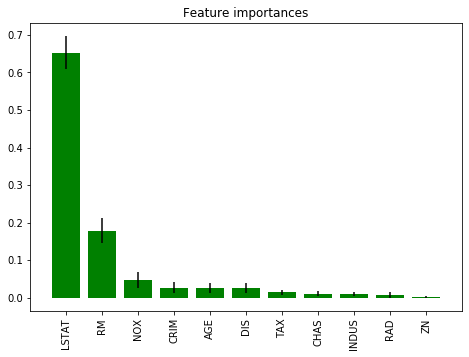

In [35]:
# Code modified from https://www.kaggle.com/kanncaa1/feature-selection-and-data-visualization
from sklearn.ensemble import RandomForestRegressor
from sklearn import preprocessing
import warnings                           # silence warnings that commonly occur with random forest
warnings.filterwarnings('ignore')     

x = df.iloc[:,[0,1,2,3,4,5,6,7,8,9,10]]              # separate DataFrames for predictor and response features
y = df.iloc[:,[11]]

lab_enc = preprocessing.LabelEncoder(); y_encoded = lab_enc.fit_transform(y) # this removes an encoding error 

random_forest = RandomForestRegressor()   # instantiate the random forest  
random_forest = random_forest.fit(x,np.ravel(y_encoded)) # fit the random forest
importances = random_forest.feature_importances_ # extract the expected feature importances
std = np.std([tree.feature_importances_ for tree in random_forest.estimators_],axis=0) # calculate stdev over trees
indices = np.argsort(importances)[::-1]   # find indicies for descending order

print("Feature ranking:")                 # write out the feature importances
for f in range(x.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

plt.subplot(111)                          # plot the feature importance 
plt.title("Feature importances")
plt.bar(range(x.shape[1]), importances[indices],
       color="g", yerr=std[indices], align="center")
plt.xticks(range(x.shape[1]), x.columns[indices],rotation=90)
plt.xlim([-1, x.shape[1]])
plt.subplots_adjust(left=0.0, bottom=0.0, right=1., top=1., wspace=0.2, hspace=0.2)
plt.show()

We plot the results again, including results from the $B$ and $\beta$ coefficients.

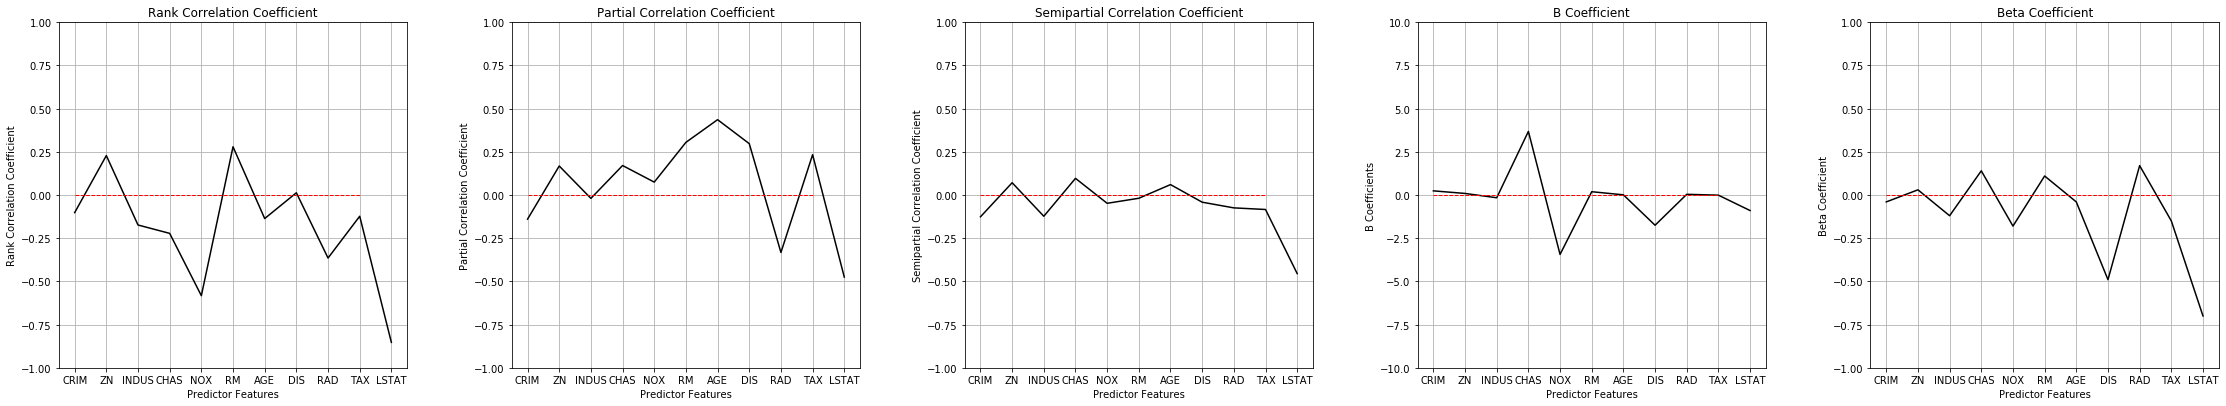

In [36]:
plt.subplot(151)
plt.plot(features,rank_correlation,color='black')
plt.plot([0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],'r--',color='red',linewidth = 1.0)
plt.xlabel('Predictor Features')
plt.ylabel('Rank Correlation Coefficient')
t = plt.title('Rank Correlation Coefficient')
plt.ylim(-1,1)
plt.grid(True)

plt.subplot(152)
plt.plot(features,partial_correlation,color='black')
plt.plot([0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],'r--',color='red',linewidth = 1.0)
plt.xlabel('Predictor Features')
plt.ylabel('Partial Correlation Coefficient')
t = plt.title('Partial Correlation Coefficient')
plt.ylim(-1,1)
plt.grid(True)

plt.subplot(153)
plt.plot(features,semipartial_correlation,color='black')
plt.plot([0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],'r--',color='red',linewidth = 1.0)
plt.xlabel('Predictor Features')
plt.ylabel('Semipartial Correlation Coefficient')
t = plt.title('Semipartial Correlation Coefficient')
plt.ylim(-1,1)
plt.grid(True)

plt.subplot(154)
plt.plot(features,b[0:11],color='black')
plt.plot([0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],'r--',color='red',linewidth = 1.0)
plt.xlabel('Predictor Features')
plt.ylabel('B Coefficients')
t = plt.title('B Coefficient')
plt.ylim(-10,10)
plt.grid(True)

plt.subplot(155)
plt.plot(features,beta[0:11],color='black')
plt.plot([0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],'r--',color='red',linewidth = 1.0)
plt.xlabel('Predictor Features')
plt.ylabel('Beta Coefficient')
t = plt.title('Beta Coefficient')
plt.ylim(-1,1)
plt.grid(True)

plt.subplots_adjust(left=0.0, bottom=0.0, right=5, top=1.2, wspace=0.3, hspace=0.2)
plt.show()

From all of these methods, I would select the following variables: LSTAT, RM, INDUS, TAX, DIS 



### 2. Second Workflow Step-Part 1 Linear Regression

Perform various regression methods to predict response feartures (MEDV) from five predictors (LSTAT,RM,INDUS,TAX,DIS)

#### Loading Data

We first load the data file and then split it into train and test datasets.

In [80]:
df_train = df.iloc[0:405,:]                                  # extract a training set, note samples are random ordered
df_train.head()   
df_test = df.iloc[405:]                                      # extract a testing set, note samples are random ordered
df_test.head()  

# extract a testing set, note samples are random ordered
df_test.head()                                              # preview the DataFrame

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,LSTAT,MEDV
405,0.00000,18.1,0.0,0.693,5.683,100.000,1.4254,24.0000,666,20.2,22.98,5.0
406,0.00000,18.1,0.0,0.659,4.138,100.000,1.1781,24.0000,666,20.2,23.34,11.9
407,0.00000,18.1,0.0,0.659,5.608,100.000,1.2852,24.0000,666,20.2,12.13,27.9
408,7.40389,0.0,18.1,0.000,0.597,5.617,97.9000,1.4547,24,666.0,26.40,17.2
409,0.00000,18.1,0.0,0.597,6.852,100.000,1.4655,24.0000,666,20.2,19.78,27.5


In [44]:
medv_train = df_train['MEDV'].values                     # make a shallow copy of the features for convenvience
df = pd.read_csv("boston house price.csv")                    
medv_test = df_test['MEDV'].values
lstat_train = df_train['LSTAT'].values
lstat_test = df_test['LSTAT'].values
indus_train = df_train['INDUS'].values
indus_test = df_test['INDUS'].values
tax_train = df_train['TAX'].values
tax_test = df_test['TAX'].values
rm_train = df_train['RM'].values
rm_test = df_test['RM'].values
dis_train = df_train['DIS'].values
dis_test = df_test['DIS'].values
n_train = len(df_train); n_test = len(df_test)              # get the number of data in training and testing


We first use scikit learn to calculate the linear regression model.

In [45]:
from sklearn import linear_model
# Step 1. Instantiate the Model 
linear_reg = linear_model.LinearRegression()
X = df_train[["LSTAT","RM","INDUS","TAX","DIS"]]
Y = df_train["MEDV"]
# Step 2: Fit the Data on Training Data
linear_reg.fit(X,Y) # fit model
Perm_model = np.linspace(0,800,10)
AI_model = np.linspace(3000,6000,10)
# Print the model parameters
print('Coefficients of LSTAT: ', str(round(linear_reg.coef_[0],3)) + '\n' + 'Coefficients of RM: ', str(round(linear_reg.coef_[1],3)) + '\n'  + 'Coefficients of INDUS: ', str(round(linear_reg.coef_[2],3)) + '\n' + 'Coefficients of TAX: ', str(round(linear_reg.coef_[3],3)) + '\n'  + 'Coefficients of DIS: ', str(round(linear_reg.coef_[4],3)) + '\n'  +'Intercept: ', str(round(linear_reg.intercept_,3))) 

Coefficients of LSTAT:  -0.984
Coefficients of RM:  0.289
Coefficients of INDUS:  -0.237
Coefficients of TAX:  -0.004
Coefficients of DIS:  -1.48
Intercept:  43.392


Variance explained: 0.57
Training: Residual: mean = -0.0, standard deviation = 6.05


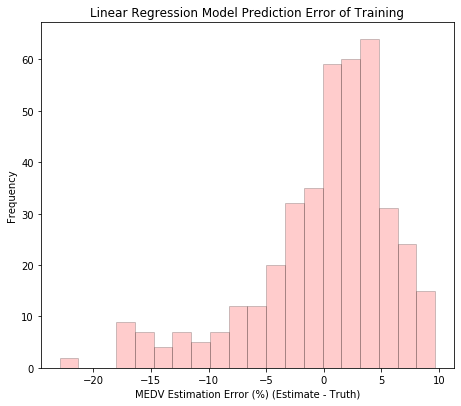

In [46]:
# Step 3: - Make predictions using the testing dataset
y_train = linear_reg.predict(X)
print('Variance explained: %.2f' % r2_score(df_train['MEDV'].values, y_train))

y_res_train = y_train - df_train['MEDV'].values
print('Training: Residual: mean = ' + str(round(np.average(y_res_train),2)) + ', standard deviation = ' + str(round(np.std(y_res_train),2)))

plt.subplot(122)
plt.hist(y_res_train, alpha = 0.2, color = 'red', edgecolor = 'black', bins=20)
plt.title('Linear Regression Model Prediction Error of Training'); plt.xlabel('MEDV Estimation Error (%) (Estimate - Truth)'); plt.ylabel('Frequency')
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.2, top=1.2, wspace=0.3, hspace=0.2)
plt.show()

Variance explained: 0.09
Testing: Residual: mean = 1.18, standard deviation = 4.77


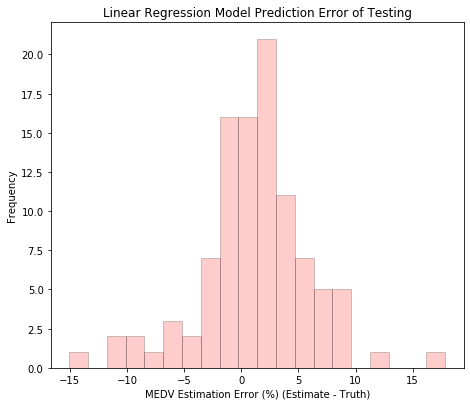

In [47]:
# Step 3: - Make predictions using the testing dataset
x_test = df_test[["LSTAT","RM","INDUS","TAX","DIS"]]
y_pred = linear_reg.predict(x_test)
print('Variance explained: %.2f' % r2_score(df_test['MEDV'].values, y_pred))

y_res_lin = y_pred - df_test['MEDV'].values
print('Testing: Residual: mean = ' + str(round(np.average(y_res_lin),2)) + ', standard deviation = ' + str(round(np.std(y_res_lin),2)))

plt.subplot(122)
plt.hist(y_res_lin, alpha = 0.2, color = 'red', edgecolor = 'black', bins=20)
plt.title('Linear Regression Model Prediction Error of Testing'); plt.xlabel('MEDV Estimation Error (%) (Estimate - Truth)'); plt.ylabel('Frequency')
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.2, top=1.2, wspace=0.3, hspace=0.2)
plt.show()

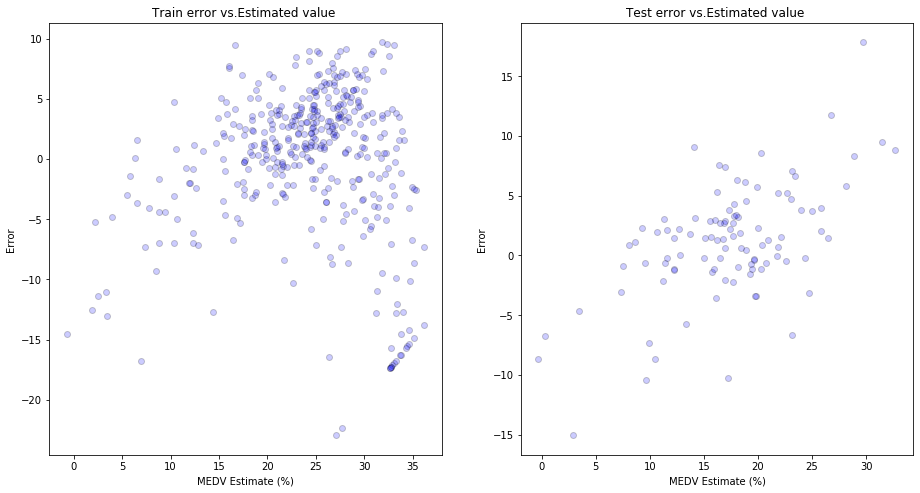

In [48]:
plt.subplot(121)
plt.plot( y_train,y_res_train, 'o', color = 'blue', alpha = 0.2, markeredgecolor = 'black')
plt.title('Train error vs.Estimated value ')
plt.xlabel('MEDV Estimate (%)')
plt.ylabel('Error ')

plt.subplot(122)
plt.plot( y_pred,y_res_lin, 'o', color = 'blue', alpha = 0.2, markeredgecolor = 'black')
plt.title('Test error vs.Estimated value ')
plt.xlabel('MEDV Estimate (%)')
plt.ylabel('Error ')
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.5, wspace=0.2, hspace=0.2)
plt.show()

### 2. Second Workflow Step- Part 2 Ridge Regression

Next try another methods to predict the models.

Let's perform ridge regression method.  In this mehod, we need to set the lambda hyperparameter.


In [55]:
lam =5857
x_train = df_train[["LSTAT","RM","INDUS","TAX","DIS"]]
x_test = df_test[["LSTAT","RM","INDUS","TAX","DIS"]]
# Step 1. Instantiate the Model 
ridge_reg = Ridge(alpha=lam)
# Step 2: Fit the Data on Training Data
ridge_reg.fit(x_train, df_train["MEDV"]) # fit model
# Print the model parameters
print('Coefficients of LSTAT: ', str(round(ridge_reg.coef_[0],3)) + '\n' + 'Coefficients of RM: ', str(round(ridge_reg.coef_[1],3)) + '\n'  + 'Coefficients of INDUS: ', str(round(ridge_reg.coef_[2],3)) + '\n' + 'Coefficients of TAX: ', str(round(ridge_reg.coef_[3],3)) + '\n'  + 'Coefficients of DIS: ', str(round(ridge_reg.coef_[4],3)) + '\n'  +'Intercept: ', str(round(ridge_reg.intercept_,3))) 


Coefficients of LSTAT:  -0.669
Coefficients of RM:  -0.019
Coefficients of INDUS:  -0.091
Coefficients of TAX:  -0.004
Coefficients of DIS:  -0.217
Intercept:  35.221


Variance explained: 0.28
Ridge: Residual: mean = 1.8, standard deviation = 3.99


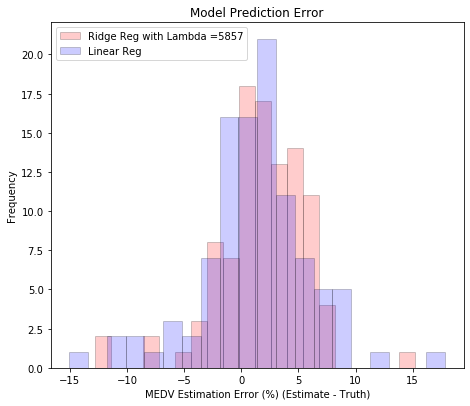

In [56]:
# Step 3: - Make predictions using the testing dataset

y_pred = ridge_reg.predict(x_test)
# Report the goodness of fit
print('Variance explained: %.2f' % r2_score(df_test['MEDV'].values, y_pred))

# Plot testing diagnostics 
plt.xlim(1.0,2.6); plt.ylim(5,24)

y_res = y_pred - df_test['MEDV'].values
print('Ridge: Residual: mean = ' + str(round(np.average(y_res),2)) + ', standard deviation = ' + str(round(np.std(y_res),2)))

plt.subplot(121)
plt.hist(y_res, alpha = 0.2, color = 'red', edgecolor = 'black', bins=20, label='Ridge Reg with Lambda ='+str(int(lam)))
plt.hist(y_res_lin, alpha = 0.2, color = 'blue', edgecolor = 'black', bins=20, label='Linear Reg')
plt.title('Model Prediction Error');
plt.xlabel('MEDV Estimation Error (%) (Estimate - Truth)'); plt.ylabel('Frequency')
plt.legend()
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.2, top=1.2, wspace=0.3, hspace=0.2)
plt.show()

we have less variance and smaller residual standard deviation.

#### Investigating the Lambda Hyperparameter

We loop over a series of lambda values and observe the change in:

In [57]:
# Arrays to store the results
ncases = 100
lamd_mat = np.logspace(np.log10(1e-5),np.log10(1e9),ncases)
var_explained_train = np.zeros(ncases); var_explained_test = np.zeros(ncases)
mse_train = np.zeros(ncases); mse_test = np.zeros(ncases)


In [58]:
 # Loop over all lambda values
for ilam in range(0,len(lamd_mat)): 
    ridge_reg = Ridge(alpha=lamd_mat[ilam])
    ridge_reg.fit(x_train, df_train["MEDV"]) # fit model

    MEDV_pred_train = ridge_reg.predict(x_train) # predict with the fit model   
    var_explained_train[ilam] = r2_score(df_train['MEDV'].values, MEDV_pred_train)
    mse_train[ilam] = mean_squared_error(df_train['MEDV'].values, MEDV_pred_train) 
    
    MEDV_pred_test = ridge_reg.predict(x_test )
    var_explained_test[ilam] = r2_score(df_test['MEDV'].values, MEDV_pred_test)
    mse_test[ilam] = mean_squared_error(df_test['MEDV'].values, MEDV_pred_test)    

imin=np.argmin(mse_test)   
tuned_lamda = int(lamd_mat[imin])                         # get the hyperparameter value with the minimum testing error
print('Minimum MSE with hyperparameter lamd = %.0f' % tuned_lamda)

(m,i) = min((v,i) for i,v in enumerate(mse_test))
print (m,i)
print(lamd_mat[i])

Minimum MSE with hyperparameter lamd = 5857
19.13509248249301 62
5857.020818056673



* Now we get the optimal lamda value =5857.

Let's plot the variance explained and MSE over training and testing data.

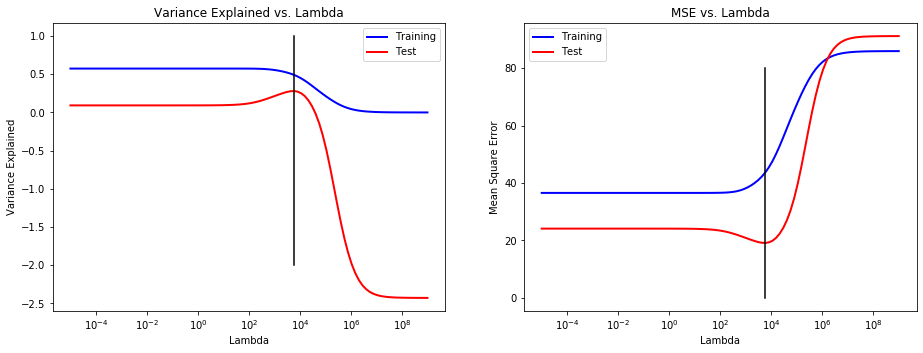

In [59]:
plt.subplot(121)
plt.plot(lamd_mat, var_explained_train,  color='blue', linewidth = 2, label = 'Training')
plt.plot(lamd_mat, var_explained_test,  color='red', linewidth = 2, label = 'Test')
plt.plot([tuned_lamda,tuned_lamda],[-2,1],color='black') # 
plt.title('Variance Explained vs. Lambda'); plt.xlabel('Lambda'); plt.ylabel('Variance Explained')
plt.xscale('log')
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.0, wspace=0.2, hspace=0.2)
plt.legend()

plt.subplot(122)
plt.plot(lamd_mat, mse_train,  color='blue', linewidth = 2, label = 'Training')
plt.plot(lamd_mat, mse_test,  color='red', linewidth = 2, label = 'Test')
plt.plot([tuned_lamda,tuned_lamda],[0,80],color='black') # vertical line at hyperparameter value that minimizes testing error 
plt.title('MSE vs. Lambda'); plt.xlabel('Lambda'); plt.ylabel('Mean Square Error')
plt.xscale('log')
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.0, wspace=0.2, hspace=0.2)
plt.legend()
plt.show()


As the lambda parameter increased, the variance explained decreased and the mean square error increased.


### 2. Second Workflow Step- Part 3 Lasso Regression

Let's use lasso methods. Here we need to do hyperparameter tuning.

In [63]:
lam_lasso = 2

# Step 1. Instantiate the Model 
lasso_reg = Lasso(alpha=lam_lasso)

# Step 2: Fit the Data on Training Data
lasso_reg.fit(x_train, df_train["MEDV"]) # fit model
print('Coefficients of LSTAT: ', str(round(lasso_reg.coef_[0],3)) + '\n' + 'Coefficients of RM: ', str(round(lasso_reg.coef_[1],3)) + '\n'  + 'Coefficients of INDUS: ', str(round(lasso_reg.coef_[2],3)) + '\n' + 'Coefficients of TAX: ', str(round(lasso_reg.coef_[3],3)) + '\n'  + 'Coefficients of DIS: ', str(round(lasso_reg.coef_[4],3)) + '\n'  +'Intercept: ', str(round(lasso_reg.intercept_,3))) 

Coefficients of LSTAT:  -0.928
Coefficients of RM:  0.072
Coefficients of INDUS:  -0.0
Coefficients of TAX:  -0.005
Coefficients of DIS:  -0.457
Intercept:  38.092


Variance explained: 0.21
Residual: mean = 1.42, standard deviation = 19.1


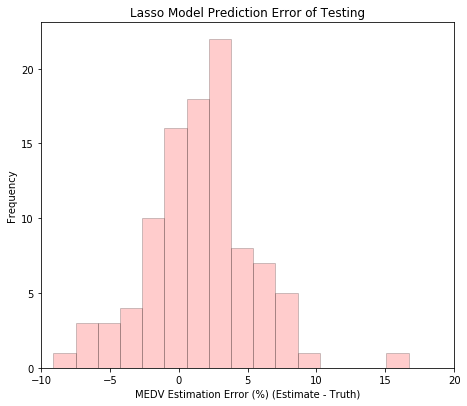

In [64]:
# Step 3: - Make predictions using the testing dataset
y_pred_test_las = lasso_reg.predict(x_test)

# Report the goodness of fit
print('Variance explained: %.2f' % r2_score(df_test['MEDV'].values, y_pred_test_las))

y_res_test_las = y_pred_test_las - df_test['MEDV'].values
print('Residual: mean = ' + str(round(np.average(y_res_test_las),2)) + ', standard deviation = ' + str(round(np.var(y_res_test_las),2)))

plt.subplot(122)
plt.hist(y_res_test_las, alpha = 0.2, color = 'red', edgecolor = 'black', bins=20)
plt.title('Lasso Model Prediction Error of Testing'); plt.xlabel('MEDV Estimation Error (%) (Estimate - Truth)'); plt.ylabel('Frequency')
plt.xlim(-10,20)
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.2, top=1.2, wspace=0.3, hspace=0.2)
plt.show()

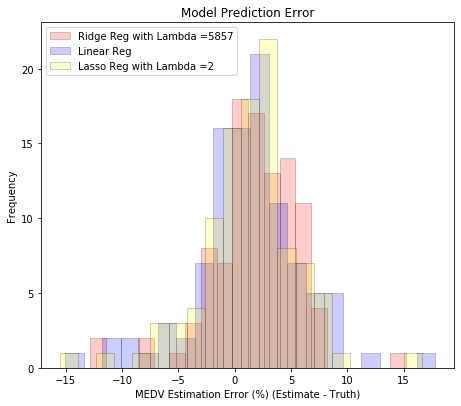

In [65]:
plt.subplot(121)
#test
plt.hist(y_res, alpha = 0.2, color = 'red', edgecolor = 'black', bins=20, label='Ridge Reg with Lambda ='+str(int(lam)))
plt.hist(y_res_lin, alpha = 0.2, color = 'blue', edgecolor = 'black', bins=20, label='Linear Reg')
plt.hist(y_res_test_las, alpha = 0.2, color = 'yellow', edgecolor = 'black', bins=20, label='Lasso Reg with Lambda ='+str(int(lam_lasso)))
plt.title('Model Prediction Error');
plt.xlabel('MEDV Estimation Error (%) (Estimate - Truth)'); plt.ylabel('Frequency')
plt.legend()
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.2, top=1.2, wspace=0.3, hspace=0.2)
plt.show()

* By comparing these models, the ridge regression model seems the best model for this dataset. It has the least variance and a smallest error.


#### Investigating the Lambda Hyperparameter

Let's look at the model behavoir over a range of features, for a range of lambda hyperparameter values.

In [66]:
# Arrays to store the results
ncases = 100
lamd_mat = np.logspace(np.log10(1e-5),np.log10(1e5),ncases)
var_explained_train = np.zeros(ncases); var_explained_test = np.zeros(ncases)
mse_train = np.zeros(ncases); mse_test = np.zeros(ncases)

In [72]:
# Loop over all lambda values
for ilam in range(0,len(lamd_mat)): 
    lasso_reg = Lasso(alpha=lamd_mat[ilam])
    lasso_reg.fit(x_train, df_train["MEDV"]) # fit model

    MEDV_pred_train = lasso_reg.predict(x_train) # predict with the fit model   
    var_explained_train[ilam] = r2_score(df_train['MEDV'].values, MEDV_pred_train)
    mse_train[ilam] = mean_squared_error(df_train['MEDV'].values, MEDV_pred_train) 
    
    MEDV_pred_test = lasso_reg.predict(x_test )
    var_explained_test[ilam] = r2_score(df_test['MEDV'].values, MEDV_pred_test)
    mse_test[ilam] = mean_squared_error(df_test['MEDV'].values, MEDV_pred_test)    

imin=np.argmin(mse_test)   
tuned_lamda = int(lamd_mat[imin])                         # get the hyperparameter value with the minimum testing error
print('Minimum MSE with hyperparameter lamd = %.0f' % tuned_lamda)

(m,i) = min((v,i) for i,v in enumerate(mse_test))
print (m,i)
print(lamd_mat[i])

Minimum MSE with hyperparameter lamd = 2
20.74982295705417 38
2.364489412645407


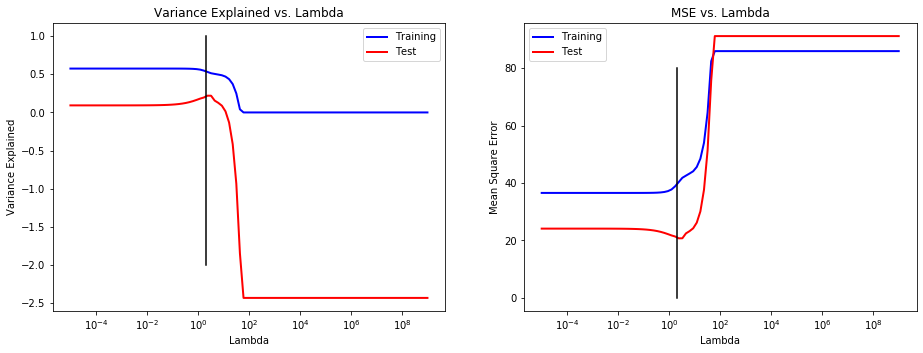

In [73]:
plt.subplot(121)
plt.plot(lamd_mat, var_explained_train,  color='blue', linewidth = 2, label = 'Training')
plt.plot(lamd_mat, var_explained_test,  color='red', linewidth = 2, label = 'Test')
plt.plot([tuned_lamda,tuned_lamda],[-2,1],color='black') # 
plt.title('Variance Explained vs. Lambda'); plt.xlabel('Lambda'); plt.ylabel('Variance Explained')
plt.xscale('log')
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.0, wspace=0.2, hspace=0.2)
plt.legend()

plt.subplot(122)
plt.plot(lamd_mat, mse_train,  color='blue', linewidth = 2, label = 'Training')
plt.plot(lamd_mat, mse_test,  color='red', linewidth = 2, label = 'Test')
plt.plot([tuned_lamda,tuned_lamda],[0,80],color='black') # vertical line at hyperparameter value that minimizes testing error 
plt.title('MSE vs. Lambda'); plt.xlabel('Lambda'); plt.ylabel('Mean Square Error')
plt.xscale('log')
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.0, wspace=0.2, hspace=0.2)
plt.legend()
plt.show()

### Results

By conducting different metrics for feature selection, I select five predictors used for house prices prediction.I also do hyperparameter tuning for the optimal predictions. Finally we obtain the results of the hyperparameters and coefficients of the regression models. By comparing the results of prediction error, I would like to choose ridge regression model as the final prediction model for this dataset.




I hope this was helpful,

*Rui Zhang*

___________________

#### Work Supervised by:

### Michael Pyrcz, Associate Professor, University of Texas at Austin 
*Novel Data Analytics, Geostatistics and Machine Learning Subsurface Solutions*

With over 17 years of experience in subsurface consulting, research and development, Michael has returned to academia driven by his passion for teaching and enthusiasm for enhancing engineers' and geoscientists' impact in subsurface resource development. 

For more about Michael check out these links:

#### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

